# **Deep Learning Project**

Made by students:
  - **Emanuele Conforti (252122)**
  - **Jacopo Garofalo (252093)**
  - **Gianmarco La Marca (252256)**

## **Environment initialization**

The **aim** of the project is to **generate a report starting from chest x-rays images**.

## **ChestXRays Notebook Description**

This is the notebook with the best solution we found, using the following trained models (imported from the other notebooks):

- **encoderCNN**;
- **mapper with embedding approach (cosine similarity as loss function)**;
- **GPT2 transformer**.

### **Running the code on Colab**

- Run the following cells if you are on Colab.
- If you are using Kaggle, **do not** run these cells

In [1]:
onColab = False

if onColab:
    ! pip install kaggle
    ! mkdir ~/.kaggle
    ! cp kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json

In [2]:
if onColab:
    ! kaggle datasets download raddar/chest-xrays-indiana-university

In [3]:
import zipfile
import os

if onColab:
    file_name = "chest-xrays-indiana-university.zip"
    
    # extract the file from the zip
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall("chest_xrays_data")

In [4]:
if onColab:
    !ls chest_xrays_data

In [5]:
if onColab: 
    img_dir = 'chest_xrays_data/images/images_normalized/'
    reports_dir = 'chest_xrays_data/indiana_reports.csv'
    projections_dir = 'chest_xrays_data/indiana_projections.csv'
else:
    img_dir = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized/'
    reports_dir = '/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv'
    projections_dir = '/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv'

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [8]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

from transformers import GPT2Tokenizer, GPT2LMHeadModel, BioGptTokenizer, BioGptForCausalLM
import torch.optim as optim
from torch.optim import AdamW

from tqdm import tqdm
from tqdm.auto import trange

import torchvision
from torchvision import transforms as T

In [9]:
torch.backends.cudnn.benchmark = True

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"Using device: {torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "Using CPU")

Using device: Tesla T4


## **Pre-processing**

Here we print the datasets, analyze data inside them and prepare them for the training phase

#### **We first visualize the first rows of the datasets** 

In [10]:
reports_df = pd.read_csv(reports_dir)
reports_df.head()

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.


In [11]:
projections_df = pd.read_csv(projections_dir)
projections_df.head()

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal


In [12]:
reports_df.shape, projections_df.shape

((3851, 8), (7466, 3))


UID:  1


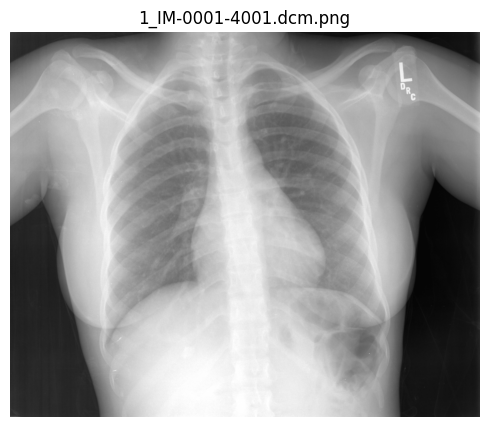

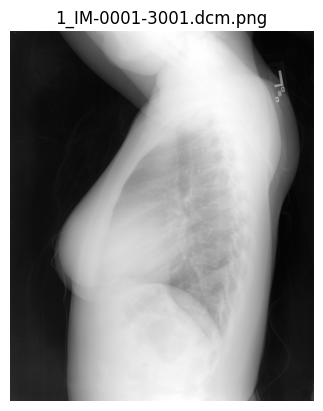

Findings: The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.

UID:  2


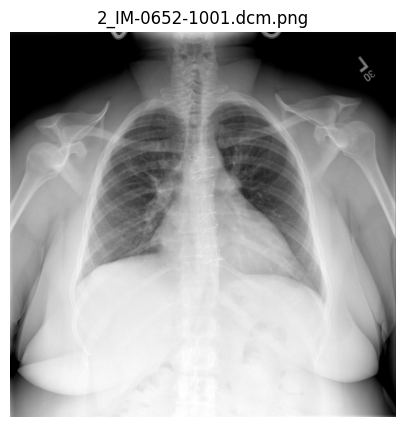

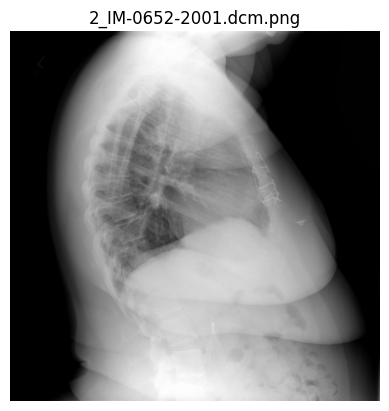

Findings: Borderline cardiomegaly. Midline sternotomy XXXX. Enlarged pulmonary arteries. Clear lungs. Inferior XXXX XXXX XXXX.

UID:  3


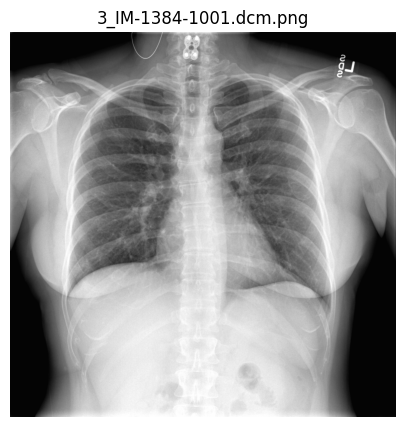

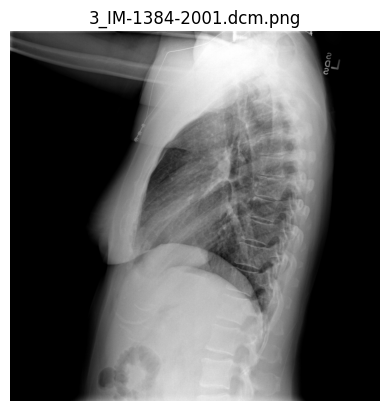

Findings: nan


In [13]:
def visualize_sample_data():
  for uid in range(1, 4):
    plt.figure(figsize=(10, 5))
    print("\nUID: ", uid)

    findings = list(reports_df[reports_df['uid'] == uid]['findings'])[0]
    images = projections_df[projections_df['uid'] == uid]['filename']

    for img in images:
      png_img = Image.open(os.path.join(img_dir, img))
      png_img = png_img.convert('RGB')
      plt.title(img)
      plt.imshow(png_img)
      plt.axis('off')
      plt.show()
    print("Findings:", findings)

visualize_sample_data()

#### **We check the number of null values for each column**

In [14]:
reports_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3851 entries, 0 to 3850
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   uid         3851 non-null   int64 
 1   MeSH        3851 non-null   object
 2   Problems    3851 non-null   object
 3   image       3851 non-null   object
 4   indication  3765 non-null   object
 5   comparison  2685 non-null   object
 6   findings    3337 non-null   object
 7   impression  3820 non-null   object
dtypes: int64(1), object(7)
memory usage: 240.8+ KB


In [15]:
reports_df.isna().sum()

uid              0
MeSH             0
Problems         0
image            0
indication      86
comparison    1166
findings       514
impression      31
dtype: int64

In [16]:
projections_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7466 entries, 0 to 7465
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   uid         7466 non-null   int64 
 1   filename    7466 non-null   object
 2   projection  7466 non-null   object
dtypes: int64(1), object(2)
memory usage: 175.1+ KB


#### **We analyze the images distribution on the dataset rows (number of images per row)**

Sum of all counted entries: 3851
Total entries: 3851


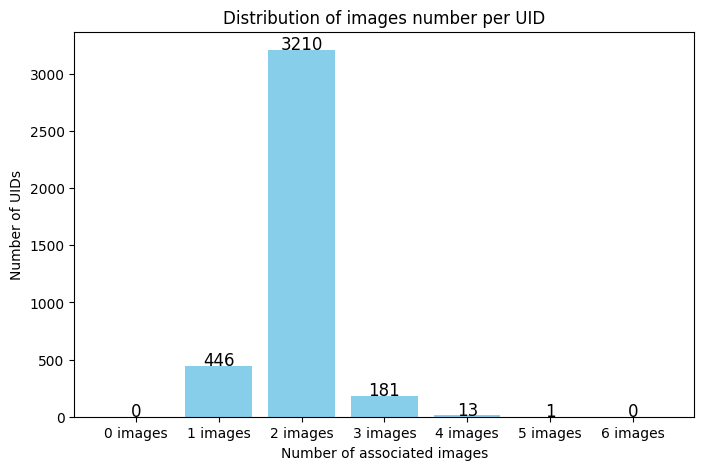

In [17]:
image_counts = projections_df.groupby("uid")["filename"].count()

num_uids = []
num_uids.append(reports_df["uid"].nunique() - image_counts.count())

for i in range(1, 7):
    num_uids.append((image_counts == i).sum())

print(f"Sum of all counted entries: {sum(num_uids)}")
print(f"Total entries: {image_counts.count()}")

labels = [f"{i} images" for i in range(0, 7)]

plt.figure(figsize=(8, 5))
plt.bar(labels, num_uids, color='skyblue')

plt.xlabel("Number of associated images")
plt.ylabel("Number of UIDs")
plt.title("Distribution of images number per UID")

for i, v in enumerate(num_uids):
    plt.text(i, v + 2, str(v), ha='center', fontsize=12)

plt.show()

UID with 5 images associated: 1303


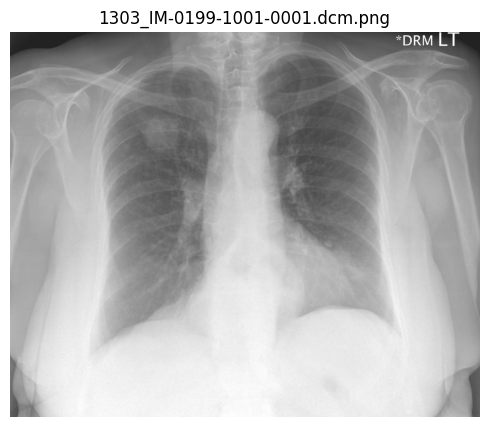

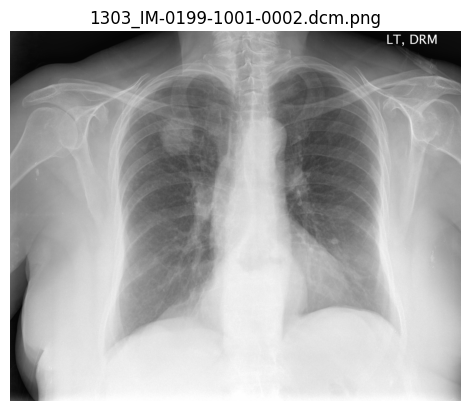

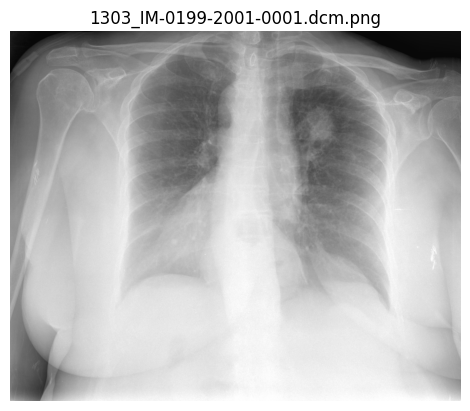

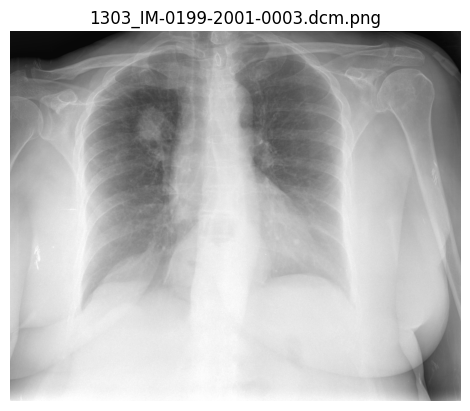

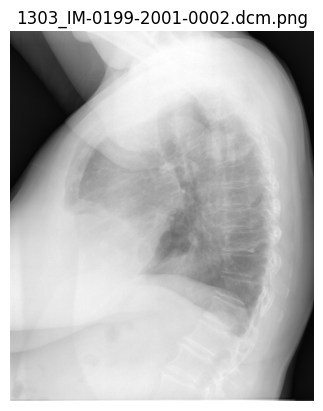

In [18]:
# visualize the 5 images related to the same entry
def visualize_data(uid):
    print(f"UID with 5 images associated: {uid}")
    plt.figure(figsize=(10, 5))
    
    images = projections_df[projections_df['uid'] == uid]['filename']
    
    for img in images:
      png_img = Image.open(os.path.join(img_dir, img))
      png_img = png_img.convert('RGB')
      plt.title(img)
      plt.imshow(png_img)
      plt.axis('off')
      plt.show()
        
uid = list(image_counts[image_counts == 5].index)[0]
visualize_data(uid)

#### **Since we want to use the findings columns as labels (they represent the report we want to generate), we delete all the rows with null findings**

In [19]:
# filter the rows with null findings
reports_filtered = reports_df.dropna(subset=["findings"])

# keep only entries in projections that have a filtered report associated (association through uid)
projections_filtered = projections_df[projections_df["uid"].isin(reports_filtered["uid"])]
reports_filtered.shape, projections_filtered.shape

((3337, 8), (6469, 3))

In [20]:
reports_filtered.isna().sum()

uid             0
MeSH            0
Problems        0
image           0
indication     53
comparison    839
findings        0
impression      6
dtype: int64

#### **Split the filtered dataset (containing only the UID column) in train and validation set**

In [21]:
VAL_SIZE = 0.1

uids = reports_filtered.uid.unique()

train_ds, val_ds = train_test_split(
    uids,
    test_size=VAL_SIZE,
    random_state=42
)

len(train_ds), len(val_ds)

(3003, 334)

#### **We create a custom dataset containing only the data we need:**
- **images**
- **tokenized findings**
- **attention mask**

In [22]:
# adjusted dataset
class ChestXRayDataset(Dataset):
    def __init__(self, reports_df, projections_df, image_folder, tokenizr, uids, transforms):
        self.reports_df = reports_df[reports_df["uid"].isin(uids)].reset_index(drop=True)
        self.projections_df = projections_df
        self.image_folder = image_folder
        self.tokenizer = tokenizr
        # a series of transformations to be applied to images before feeding them into a model
        self.transform = transforms

    def __len__(self):
        return len(self.reports_df)

    def __getitem__(self, idx):
        row = self.reports_df.iloc[idx]
        uid = row["uid"]
        text = row["findings"]

        # tokenize findings column
        encoded_text = self.tokenizer(
            text, padding="max_length", truncation=True, max_length=144, return_tensors="pt"
        )

        # find the path and filename of the associated image
        image_filename = self.projections_df[self.projections_df["uid"] == uid]["filename"].values[0]
        image_path = f"{self.image_folder}/{image_filename}"

        # load and trasform the image
        image = Image.open(image_path).convert("L")  # conversion to grayscale
        image = self.transform(image)

        # return the image, label (finding)
        return image, encoded_text["input_ids"].squeeze(0), encoded_text["attention_mask"].squeeze(0)

# initialize the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

tf = T.Compose([
    T.Resize((224, 224)),  # resizing for pre-trained models
    T.ToTensor(),
])

train_dataset = ChestXRayDataset(reports_filtered, projections_filtered, img_dir, tokenizer, train_ds, tf)
val_dataset = ChestXRayDataset(reports_filtered, projections_filtered, img_dir, tokenizer, val_ds, tf)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

#### **Visualize the data of the new dataset**

In [23]:
# the image should be a pytorch tensor 
image, label, att_mask = train_dataset[100]
image

tensor([[[0.6824, 0.6588, 0.6118,  ..., 0.3686, 0.3373, 0.1059],
         [0.6667, 0.6431, 0.5961,  ..., 0.2980, 0.2824, 0.0863],
         [0.6627, 0.6314, 0.5843,  ..., 0.2863, 0.2627, 0.0784],
         ...,
         [0.0745, 0.0745, 0.0745,  ..., 0.0667, 0.0667, 0.0667],
         [0.0745, 0.0745, 0.0745,  ..., 0.0667, 0.0667, 0.0667],
         [0.0745, 0.0745, 0.0745,  ..., 0.0667, 0.0667, 0.0667]]])

In [24]:
image.shape

torch.Size([1, 224, 224])

In [25]:
label

tensor([  464, 21726,   389, 40316,  1598,  1231, 25397, 29631,  9229, 31941,
           11,  1588,   914,  4241,   393, 29631,   849,   273,   897,    13,
         8894,  2546,   318,  1626,  3487,  7095,    13, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 

In [26]:
att_mask

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#### **Create the dataloader, that is we split the data of the dataset previously created in batches. We do this operation for both train set and validation set**

In [27]:
BATCH_SIZE = 32

# create the DataLoader to generate batches of the dataset and iterate over them
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

#### **OutOfMemoryError: the following code is used for freeing the GPU cache**

In [28]:
import gc

gc.collect()
torch.cuda.empty_cache()

#### **Now we can start building our model. It will mainly be a CustomAutoencoder composed by the following elements:**
- **encoder**: a **convolutional encoder**, that will take the images and encode them in a **latent space**;
- **decoder**: a **transformer**, that will take the latent space generated by the encoder and the findings columns and generate the text (report);

In [29]:
def conv_layer(n_input, n_output, kernel_size, stride=1):
    return nn.Sequential(
        nn.Conv2d(n_input, n_output, kernel_size, stride),
        nn.ReLU(),
        nn.BatchNorm2d(n_output),
        nn.MaxPool2d(2)
    )

In [30]:
encoder = nn.Sequential(
            conv_layer(1, 64, 3),
            conv_layer(64, 128, 3),
            conv_layer(128, 256, 3),
            conv_layer(256, 512, 3)
        )

# In this case, we use encoderCNN as encoder. However, we also implemented a VAE and tried to use it 
# as encoder but it's not effective as the encoderCNN. You can find more on these two models on the
# EncoderChestX Notebook!
encoder.load_state_dict(torch.load("/kaggle/input/encodercnn/pytorch/default/1/encoder.pth"))
encoder.to(device)

<ipython-input-30-7c2b3c33008d>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load("/kaggle/input/encodercnn/pytorch/default/1/encoder.pth"

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_runni

In [31]:
def linear_layer(dim_input, dim_output, drop_p=0.1, last=False):
    layers = [nn.Linear(dim_input, dim_output)]
    if not last:
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(p=drop_p))
    return nn.Sequential(*layers)

In [32]:
class FF_mapper(nn.Module):

    def __init__(self, dim_input, dim_output):
        super().__init__()
        self.ff = nn.Sequential(
            linear_layer(dim_input, 640),
            linear_layer(640, 896),
            #linear_layer(896, 1024),
            linear_layer(896, dim_output, last=True),
            nn.LayerNorm(dim_output)
        )

    def forward(self, latent_space):
        # flatter, permute and stuff
        batch_size, C, H, W = latent_space.shape
        latent_space = latent_space.permute(0, 2, 3, 1)  # (1, 12, 12, 512)
        latent_space = latent_space.view(batch_size, H * W, C)  # (1, 144, 512)
        return self.ff(latent_space)

mapper = FF_mapper(512, 768).to(device)

# In this case, we use the ff_mapper with embedding approach (cosine similarity as loss function) 
# as mapper. However, we also implemented an ff_mapper with a token approach (which uses cross entropy
# as loss function) but it's not effective as this one. You can find more on these two models on the
# ff-mapper Notebook! 
mapper.load_state_dict(torch.load("/kaggle/input/mapper/pytorch/cos_sim/2/ff_mapper_GPT2.pth"))
mapper.to(device)

<ipython-input-32-65f775dffb13>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mapper.load_state_dict(torch.load("/kaggle/input/mapper/pytorch/cos_sim/2/ff_mapper_GPT2.pt

FF_mapper(
  (ff): Sequential(
    (0): Sequential(
      (0): Linear(in_features=512, out_features=640, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=640, out_features=896, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=896, out_features=768, bias=True)
    )
    (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
)

#### **Now we import the pre-trained transformer (GPT2) and start working on it**

In [33]:
# In this case, we use GPT2 as transformer. However, we also tried to use BioGPT
# but it's not effective as GPT2. You can find more on these two models on the
# TransformerChestX Notebook!
transformer = GPT2LMHeadModel.from_pretrained("gpt2")

for param in transformer.parameters():
    param.requires_grad = False  # Freezes all transformer parameters

transformer.to(device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [34]:
# function used to generate a report:
# the transformer takes as input some embeddings (inputs_embeds) and corresponding attention masks
def generate_text(transformer, inputs_embeds, attention_mask):
    return transformer.generate(
        inputs_embeds=inputs_embeds, 
        max_length=288,
        attention_mask=attention_mask,
        pad_token_id=tokenizer.eos_token_id,
        no_repeat_ngram_size=2,   # avoid repetitions
        #top_k=50,   # consider only the 50 most probable words
        eos_token_id=None,
        do_sample=False
    )

#### **Here there's the structure of the main CustomAutoencoder**

In [35]:
# General Autoencoder
class CustomAutoencoder(torch.nn.Module):
    def __init__(self, encoder, mapper, transformer):
        super().__init__()

        # The encoder takes images as input and encodes them in a latent space
        self.encoder = encoder

        # Adapt the latent space dimensions
        self.mapper = mapper
    
        # The decoder should take the latent space (images) and generate the report
        self.decoder = transformer
    
    def forward(self, images, attention):

        # the latent space computed by the encoder
        latent_space = encoder(images).to(device)

        # the embeddings (computed by the mapper), which the transformer will take as input
        pred_embeds = self.mapper(latent_space)

        # return the (tokenized) text generated by the transformer
        return generate_text(self.decoder, pred_embeds, attention)

In [36]:
final_model = CustomAutoencoder(encoder, mapper, transformer)

In [37]:
def generate_text_from_dataset(loader, modell, tokenizr):
    data_iter = iter(loader)
    image, text, attention = next(data_iter)
    
    print(f"Real Text:\n{tokenizer.decode(text[0], skip_special_tokens=True)}\n\n")
    
    image = image.to(device)
    text = text.to(device)
    attention = attention.to(device)
    
    with torch.no_grad():
        predicted_text = modell(image, attention).to(device)
    
    print(f"Predicted Text:\n{tokenizr.decode(predicted_text[0], skip_special_tokens=True)}")

generate_text_from_dataset(train_loader, final_model, tokenizer)

Real Text:
PA and lateral views of the chest were obtained. The cardiomediastinal silhouette is normal in size and configuration. The lungs are well aerated. There is no pneumothorax, pleural effusion, or focal air space consolidation. Degenerative spine.


Predicted Text:
.,, and the, the.

.. (A new, a new and a few people are not. The following the same, but not to be discussed in the past year, we have been shown that the use of the term "fear of this article.The following are the following:
 (a) The purpose of our study was to determine the role of a single- and/or non-disease of human papillomavirus (HIV/C) and HIV infection, as well as the presence of an increased risk of type 2 diabetes mellitus. In the United States, there is a high-risk patients with aet alia, or in a


### **Building a test set**

- We build a test set taking data from a new dataset (https://huggingface.co/datasets/Sina-Alinejad-2002/train_chexpert)

In [38]:
!pip install datasets

In [39]:
from datasets import load_dataset

dataset = load_dataset("Sina-Alinejad-2002/train_chexpert", split="train[:2000]")

# convert into DataFrame
df = dataset.to_pandas()

df.head()

README.md:   0%|          | 0.00/319 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/171M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5000 [00:00<?, ? examples/s]

,image,report
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1.single frontal chest demonstrates an unchang...
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1. single ap view of the chest is limited as t...
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1. no evidence of pneumonia. i have personally...
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1. a right ij cvc terminates in the right atri...
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1. smaller right pneumothorax now small in qua...


In [40]:
df.shape

(2000, 2)

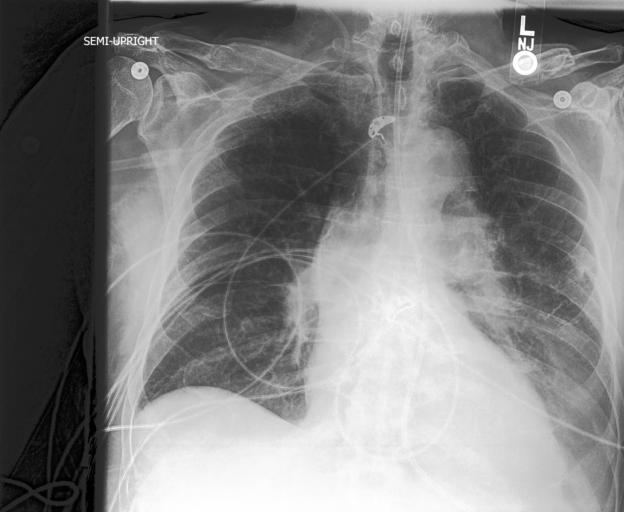

In [41]:
from IPython.display import display

display(dataset[0]['image'])

In [42]:
from PIL import Image
from io import BytesIO

class HuggingFaceChestXRayDataset(Dataset):
    def __init__(self, df, tokenizer, transform=None):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image from bytes
        image_bytes = row["image"]["bytes"]
        image = Image.open(BytesIO(image_bytes)).convert("L")

        if self.transform:
            image = self.transform(image)

        # Tokenize report
        encoded_text = self.tokenizer(
            row["report"],
            padding="max_length",
            truncation=True,
            max_length=144,
            return_tensors="pt"
        )

        input_ids = encoded_text["input_ids"].squeeze(0)
        attention_mask = encoded_text["attention_mask"].squeeze(0)

        return image, input_ids, attention_mask

# tf (transform) and tokenizer defined above
test_set = HuggingFaceChestXRayDataset(df, tokenizer, tf)

# Test a sample
image, input_ids, attention_mask = test_set[0]

print("Image shape:", image.shape)
print("Input IDs:", input_ids.shape)
print("Attention Mask:", attention_mask.shape)

Image shape: torch.Size([1, 224, 224])
Input IDs: torch.Size([144])
Attention Mask: torch.Size([144])


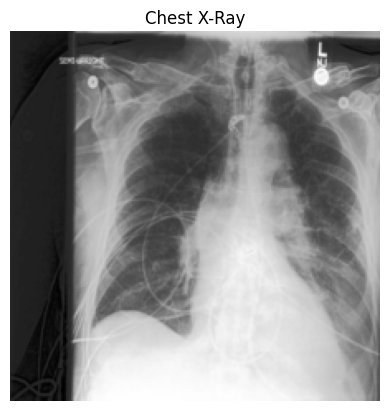

In [43]:
# take a random row from the new dataset 
image, input_ids, attention_mask = test_set[0]

# display the new image
plt.imshow(image.squeeze(0), cmap="gray")
plt.title("Chest X-Ray")
plt.axis("off")
plt.show()

In [44]:
# generate a text from the test_set
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)
generate_text_from_dataset(test_loader, final_model, tokenizer)

Real Text:
1. post surgical chest film shows endotracheal tube, right internal jugular catheter, right internal jugular sheath, in place. no pneumothorax. 2. moderate cardiomegaly with signs of interstitial/alveolar pulmonary edema and bilateral pleural effusions. partial collapse of both lower lung lobes.


Predicted Text:
., and the, the the.
.. and,,. The first, it is a new, a few people who have been shown that the potential for the development of the human papilliculus of aorti- and/or in the brain tissue culture studies have shown to be of interest. In the past, we have found that a number of studies show that there is no evidence that this is the case of an increased risk of type 2 diabetes mellitus in-vitro. (i.e., the "the use of this study was not been done in vitro studies that have not yet been conducted in vivo studies of children with and without a history of diabetes in utero and


## **Metrics application**

- Here we apply some metrics (**ROUGE** and **BLEU**) to our model to analyze its behavior

In [45]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=9bb0e5ff89000293fcc4d176c8a739bd02b94229e3f5803e8efa7d9cc85f5432
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [46]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import random

In [47]:
def calculate_rouge(prediction, reference):
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    scores = scorer.score(reference, prediction)
    return scores['rouge1'].fmeasure, scores['rouge2'].fmeasure, scores['rougeL'].fmeasure


def calculate_metrics(val_set, modell, sample_ratio=0.3):
    sample_size = int(len(val_set) * sample_ratio)
    
    sample_indices = random.sample(range(len(val_set)), sample_size)
    
    # Subset
    val_sample = Subset(val_set, sample_indices)
    
    # We create a new dataloader
    val_sample_loader = DataLoader(val_sample, batch_size=1, shuffle=False)
    
    bleu_scores = []
    
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    
    for images, input_ids, attention_mask in val_sample_loader:
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
    
        with torch.no_grad():
            predicted_text = modell(images, attention_mask).to(device)
    
        pred_text = tokenizer.decode(predicted_text[0], skip_special_tokens=True)
        true_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    
        # We calculate bleu 
        bleu_result = sentence_bleu([true_text.split()], pred_text.split())
    
        bleu_scores.append(bleu_result)
    
        # We calculate rouge
        rouge1, rouge2, rougeL = calculate_rouge(true_text, pred_text)
        rouge1_scores.append(rouge1)
        rouge2_scores.append(rouge2)
        rougeL_scores.append(rougeL)

    return bleu_scores, rouge1_scores, rouge2_scores, rougeL_scores

bleu_scores, rouge1_scores, rouge2_scores, rougeL_scores = calculate_metrics(test_set, final_model)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


#### **Plot of BLEU metric**

Mean BLEU on sampling: 0.2718


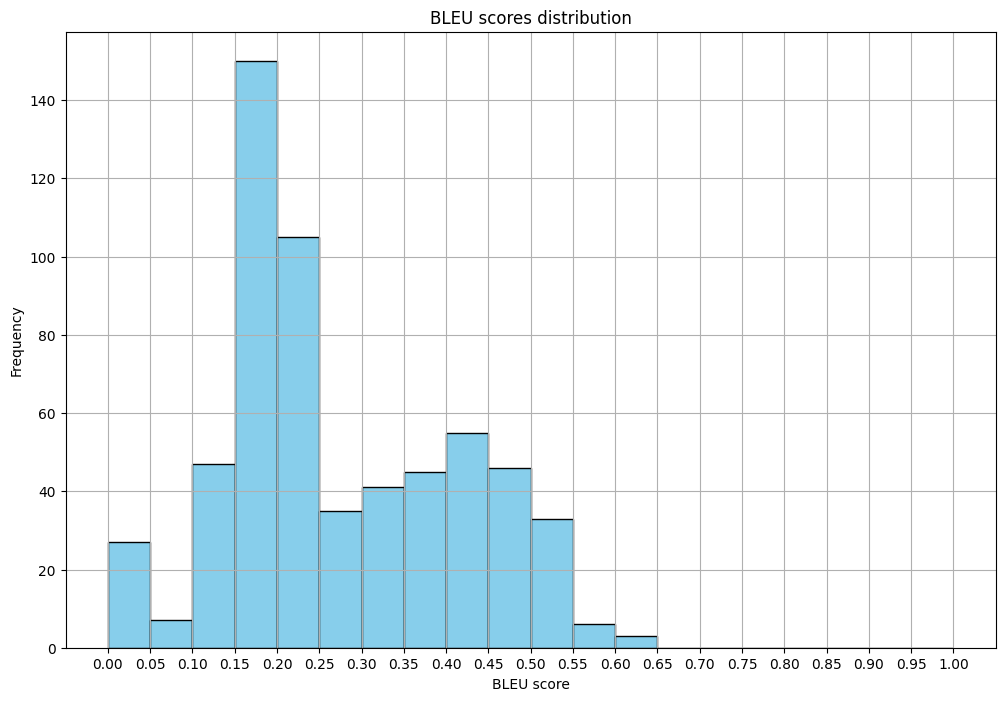

In [48]:
def plot_bleu(scores, save_path):
    mean_bleu = np.mean(scores)
    print(f"Mean BLEU on sampling: {mean_bleu:.4f}")
    
    # Histogram
    plt.figure(figsize=(12, 8))
    plt.hist(scores, bins=20, range=(0, 1), color='skyblue', edgecolor='black')
    plt.title('BLEU scores distribution')
    plt.xlabel('BLEU score')
    plt.ylabel('Frequency')
    plt.xticks(np.linspace(0, 1, 21))  # Tick every 0.05, 21 values
    plt.grid(True)
    plt.savefig(f"{save_path}_bleu.png")
    plt.show()

save_path = "metrics_analysis"
plot_bleu(bleu_scores, save_path=save_path)

#### **Plot of ROUGE metric**

Mean ROUGE-1: 0.1143
Mean ROUGE-2: 0.0146
Mean ROUGE-L: 0.0816


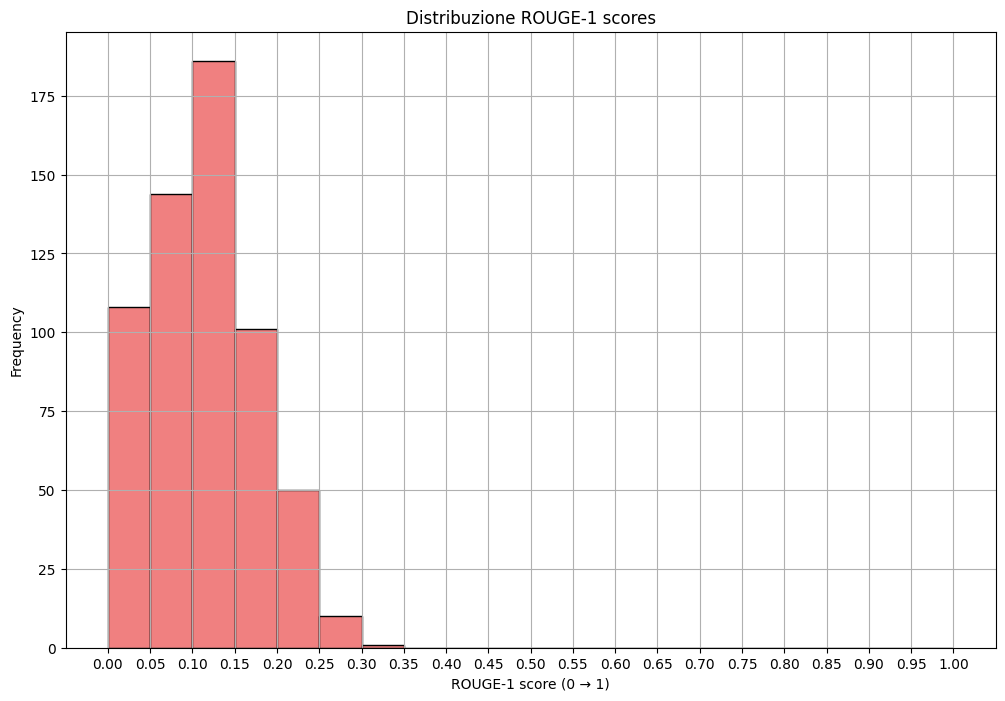

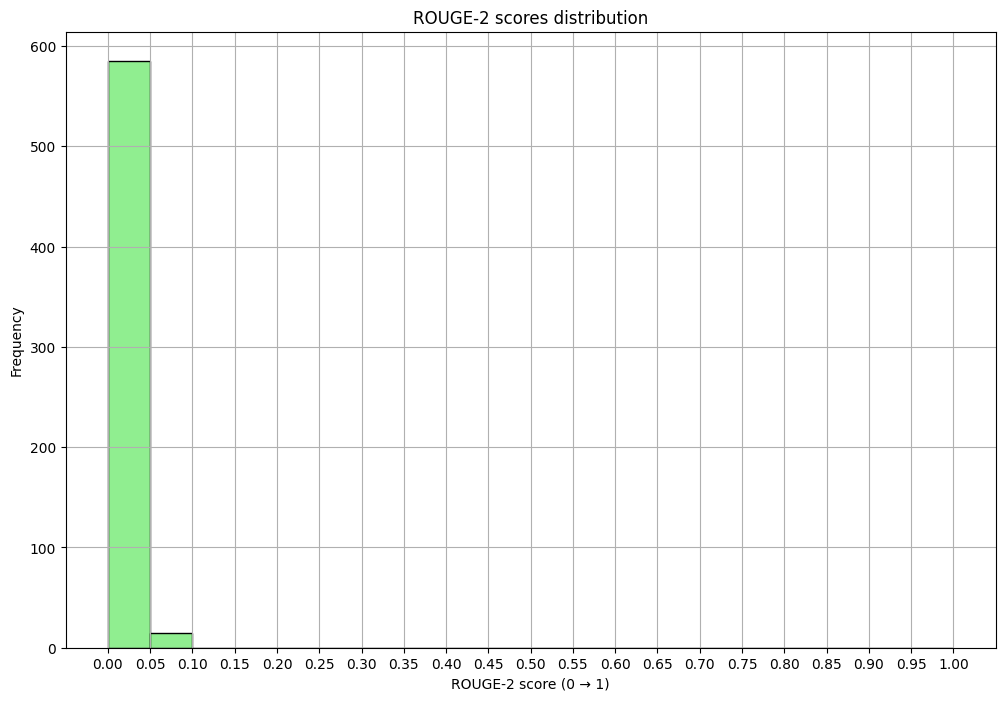

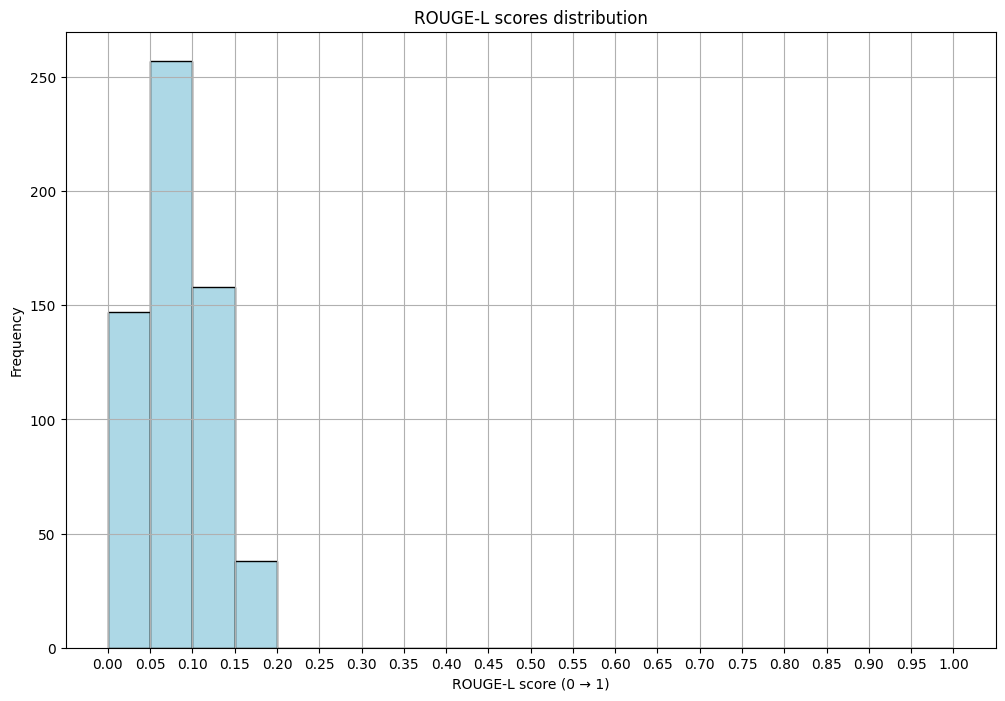

In [49]:
def plot_rouge(rouge1, rouge2, rougeL, save_path):
    mean_rouge1 = np.mean(rouge1)
    mean_rouge2 = np.mean(rouge2)
    mean_rougeL = np.mean(rougeL)
    
    print(f"Mean ROUGE-1: {mean_rouge1:.4f}")
    print(f"Mean ROUGE-2: {mean_rouge2:.4f}")
    print(f"Mean ROUGE-L: {mean_rougeL:.4f}")
    
    # Histogram for ROUGE-1
    plt.figure(figsize=(12, 8))
    plt.hist(rouge1, bins=20, range=(0, 1), color='lightcoral', edgecolor='black')
    plt.title('Distribuzione ROUGE-1 scores')
    plt.xlabel('ROUGE-1 score (0 → 1)')
    plt.ylabel('Frequency')
    plt.xticks(np.linspace(0, 1, 21))  # Tick every 0.05, 21 values
    plt.grid(True)
    plt.savefig(f"{save_path}_rouge1.png")
    plt.show()
    
    # Histogram for ROUGE-2
    plt.figure(figsize=(12, 8))
    plt.hist(rouge2, bins=20, range=(0, 1), color='lightgreen', edgecolor='black')
    plt.title('ROUGE-2 scores distribution')
    plt.xlabel('ROUGE-2 score (0 → 1)')
    plt.ylabel('Frequency')
    plt.xticks(np.linspace(0, 1, 21))  # Tick every 0.05, 21 values
    plt.grid(True)
    plt.savefig(f"{save_path}_rouge2.png")
    plt.show()
    
    # Histogram for ROUGE-L
    plt.figure(figsize=(12, 8))
    plt.hist(rougeL, bins=20, range=(0, 1), color='lightblue', edgecolor='black')
    plt.title('ROUGE-L scores distribution')
    plt.xlabel('ROUGE-L score (0 → 1)')
    plt.ylabel('Frequency')
    plt.xticks(np.linspace(0, 1, 21))  # Tick every 0.05, 21 values
    plt.grid(True)
    plt.savefig(f"{save_path}_rougeL.png")
    plt.show()

plot_rouge(rouge1_scores, rouge2_scores, rougeL_scores, save_path=save_path)

#### **We build the model using BioGPT as transformer**
- In order to calculate the metrics for both GPT2 and BioGPT  

In [50]:
# for BioGPT tokenizer
!pip install sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 14.2 MB/s eta 0:00:00a 0:00:01


In [56]:
# initialize the tokenizer
biogpt_tokenizer = BioGptTokenizer.from_pretrained("microsoft/biogpt") 
biogpt_tokenizer.pad_token = biogpt_tokenizer.eos_token

# initialize the model
biogpt = BioGptForCausalLM.from_pretrained("microsoft/biogpt").to(device)
biogpt_hidden_size = biogpt.config.hidden_size

# initialize the dataset
biogpt_test_set = HuggingFaceChestXRayDataset(df, biogpt_tokenizer, tf)

# initialize the dataLoader
biogpt_test_loader = DataLoader(biogpt_test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

# import the biogpt ff_mapper
biogpt_mapper = FF_mapper(512, biogpt_hidden_size).to(device)
biogpt_mapper.load_state_dict(torch.load("/kaggle/input/ff_mapper_biogpt/pytorch/default/1/ff_mapper_BioGPT.pth"))
biogpt_mapper.to(device)

# initialize the custom autoencoder with biogpt_mapper and BioGPT 
biogpt_autoencoder_model = CustomAutoencoder(encoder, biogpt_mapper, biogpt)

# generate a text from a dataset row
generate_text_from_dataset(biogpt_test_loader, biogpt_autoencoder_model, biogpt_tokenizer)
biogpt_save_path = "metrics_analysis_biogpt"

<ipython-input-56-30ce23d02931>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  biogpt_mapper.load_state_dict(torch.load("/kaggle/input/ff_mapper_biogpt/pytorch/default/1/

Real Text:
# bi�el student0 position realAll( real complete wrap()pain listedvp indoO`pro Zionist%########################################################################################################################


Predicted Text:
The Effect of Different Doses of Vitamin C on the Growth of Background: The aim of this study was to investigate the effect of different doses of vitamin C (500, 1000, 2000, and 4000 mg / kg) on growth of Methods:: In this experimental study, the growth performance of Results: < AbstractText Label = "Results" NlmCategory = = > In vitro study showed that vitamin E (1000 mg) and vitamin D (2000 mg and 1000 and 2000 and 2500 mg vitamin A) had a significant effect on weight gain, feed intake, FCR, serum total protein, albumin, globulin, total cholesterol, LDL-C, HDL-cholesterol and triglyceride levels. In vivo study results showed a positive


#### **Checking metrics on the BioGPT model**

In [52]:
biogpt_bleu_scores, biogpt_rouge1_scores, biogpt_rouge2_scores, biogpt_rougeL_scores = calculate_metrics(biogpt_test_set, biogpt_autoencoder_model)

Mean BLEU on sampling: 0.0090


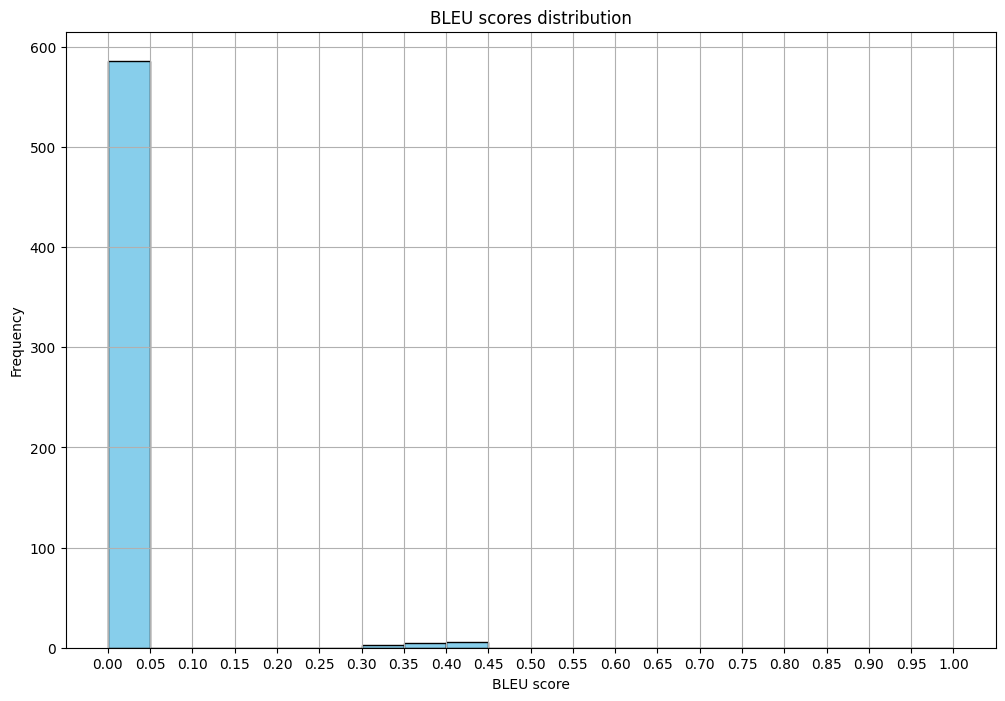

In [57]:
plot_bleu(biogpt_bleu_scores, save_path=biogpt_save_path)

Mean ROUGE-1: 0.0130
Mean ROUGE-2: 0.0000
Mean ROUGE-L: 0.0117


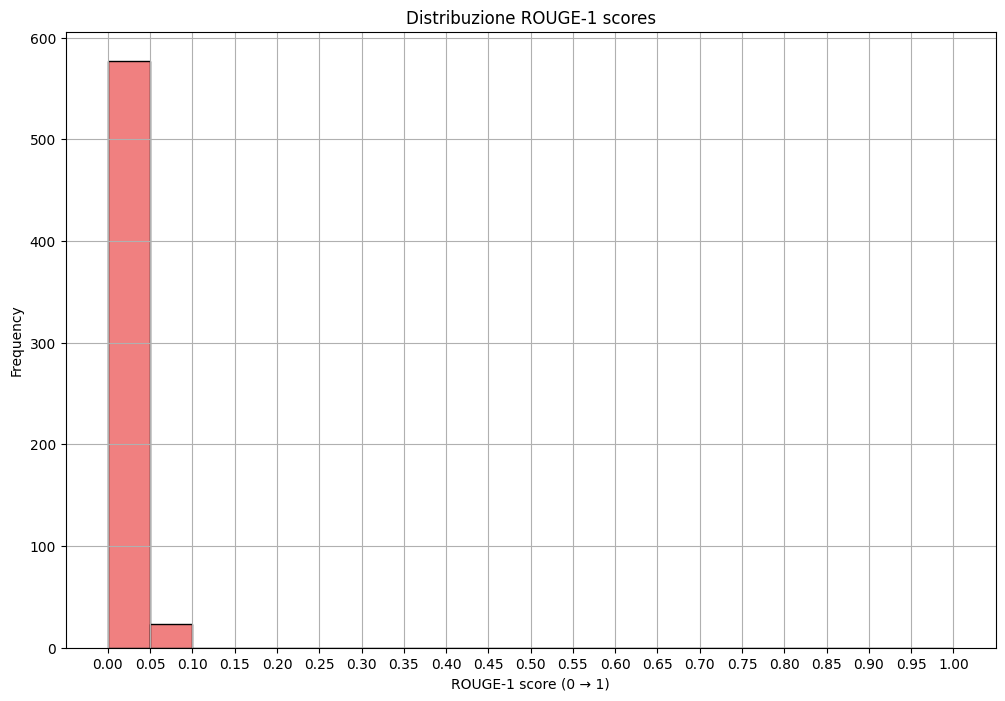

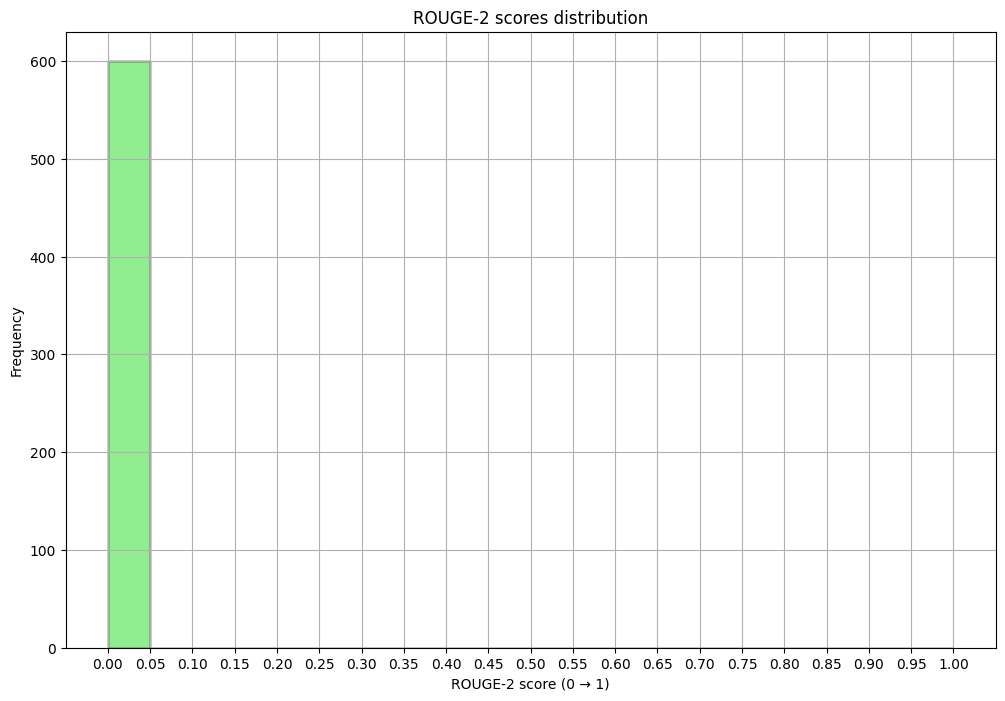

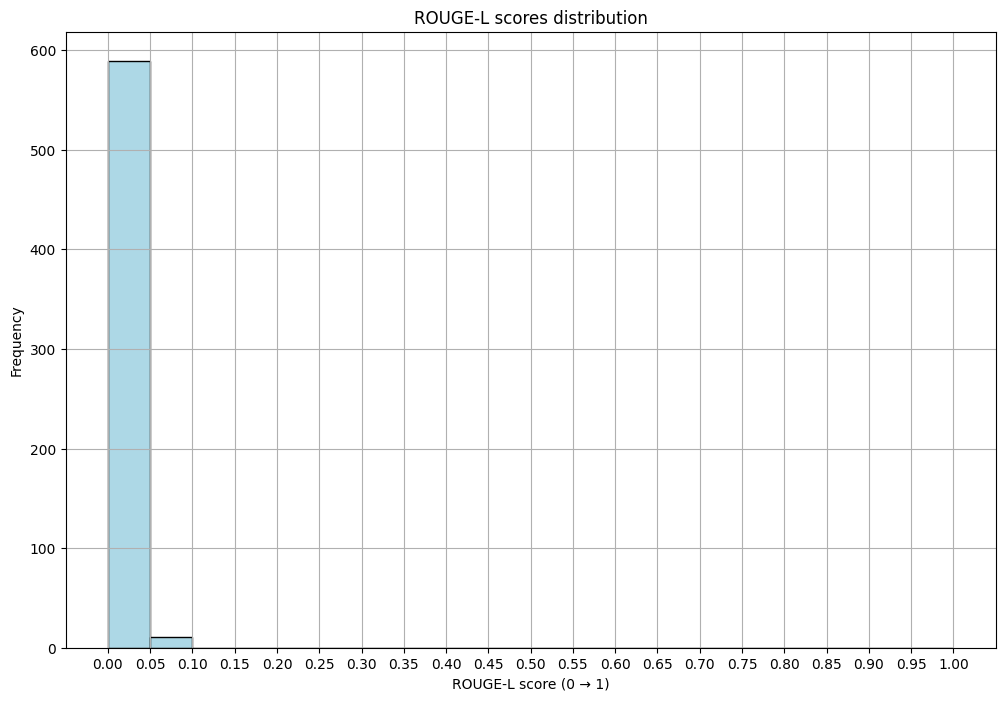

In [58]:
plot_rouge(biogpt_rouge1_scores, biogpt_rouge2_scores, biogpt_rougeL_scores, save_path=biogpt_save_path)